In [1]:
##### import stuff ###### 
import numpy as np 
import pandas as pd 
from covid19dh import covid19
from datetime import date
from Get_covid_data import get_data
import pymc3 as pm
import pandas as pd 
import numpy as np 
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import os 
import theano
import theano.tensor as tt 
import random
import fns as f

In [ ]:
###### Part 1: the data we receive #####
df = get_data(level = 2, start = date(2020,3,6)) #can get more or less data here.
df = df[df["administrative_area_level_2"].isin(["Colorado", "Mississippi", "New York", "Texas"])]
df["t"] = df["date"]
df["y"] = df["new_infected_pr_capita"]
df["idx"] = df["administrative_area_level_2"]
df = df[["idx", "t", "y"]]

In [4]:
df = pd.read_csv("../data/archive/Alcohol_Sales.csv")
df.head()

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [5]:
## user also gives us names 
time = "DATE"
values = "S4248SM144NCEN"
index = "None"
split = .70

In [6]:
###### Part 2: our preprocessing ######
index_codes = "idx_code"
time_codes = "t_code"

In [8]:
## handling idx if missing
if index == "None": 
    df[index] = np.zeros(len(df))
    df[index_codes] = np.zeros(len(df))

In [9]:
## create idx codes
df[index_codes] = pd.Categorical(df[index]).codes

## handling time 
if type(df[time]) != int: 
    df[time_codes] = df.groupby([index]).cumcount()+0

In [12]:
## train / test split 
train, test = f.train_test(df, time_codes, train_size = split)

In [74]:
## variables for test 
t1_test = ((test[time_codes] - df[time_codes].min()) / (df[time_codes].max() - df[time_codes].min())).values
t2_test = np.unique(t1_test)
t3_test = len(t2_test)
y_test = ((test[values] - df[values].min()) / (df[values].max() - df[values].min())).values
idx_test = test[index_codes].values
n_test = len(np.unique(idx_test))

## variables for train
t1_train = ((train[time_codes] - train[time_codes].min()) / (train[time_codes].max() - train[time_codes].min())).values
t2_train = np.unique(t1_train) 
t3_train = len(t2_train)
y_train = ((train[values] - train[values].min()) / (train[values].max() - train[values].min())).values
idx_train = train[index_codes].values
n_train = len(np.unique(idx_train))

In [14]:
##### Part 3: set up periods #######

## NB: we assume that input is in days. 

## common across week & month (I guess)
## NB: deviation might as well just go in on each place then.
divisor = 7
deviation = 0.2

## week 
n_week_components = 4
week_mu = 7
week_sd = week_mu/divisor

## normalize week.
p_week_mu = (week_mu - train[time_codes].min()) / (train[time_codes].max() - train[time_codes].min())
p_week_sd = (week_sd - train[time_codes].min()) / (train[time_codes].max() - train[time_codes].min())
beta_week_sd = deviation
p_week_mu

## month
n_month_components = 4
month_mu = 30
month_sd = month_mu/divisor

## normalize month.
p_month_mu = (month_mu -  train[time_codes].min()) / (train[time_codes].max() - train[time_codes].min())
p_month_sd = (month_sd - train[time_codes].min()) / (train[time_codes].max() - train[time_codes].min())
beta_month_sd = deviation


In [15]:
##### Part 4: Seasonal component #####
def seasonal_component(
    name, 
    name_beta, 
    mu, 
    sd, 
    beta_sd, 
    n_components, 
    shape,
    t2,
    t3):
    
    p = pm.Beta(name, 
                mu = mu, 
                sd = sd, 
                shape = shape)

    period_x = 2*np.pi*np.arange(1, n_components+1)
    period_stack_x = np.stack([period_x for i in range(shape)])
    period_scaled_x = period_stack_x.T / p
    x = tt.reshape(period_scaled_x[:, :, None] * t2, (n_components, shape*t3))
    x_waves = tt.concatenate((tt.cos(x), tt.sin(x)), axis = 0)

    beta_waves = pm.Normal(
        name_beta, 
        mu = 0,
        sd = beta_sd, 
        shape = (2*n_components, shape))

    ### flatten waves
    lst = []
    index_first = 0
    index_second = t3
    for i in range(shape): 
        tmp = pm.math.dot(x_waves.T[index_first:index_second, :], beta_waves[:, i])
        lst.append(tmp)
        index_first += t3
        index_second += t3
    stacked = tt.stack(lst)
    x_flat = tt.flatten(stacked)
    
    return (beta_waves, x_waves, x_flat)


In [16]:
##### Part 5: run the model ######
with pm.Model() as m0: 
    
    # shared 
    t1_shared = pm.Data('t1_shared', t1_train)
    t2_shared = pm.Data('t2_shared', t2_train)
    t3_shared = pm.Data('t3_shared', np.array(t3_train))
    idx_shared = pm.Data('idx_shared', idx_train)
    
    # prepare fourier week
    #seasonal_component(name, name_beta, mu, sd, beta_sd, n_components, shape, time_scaled)
    beta_week_waves, x_week_waves, week_flat = seasonal_component(name = "p_week",
                                                       name_beta = "beta_week_waves",
                                                       mu = p_week_mu,
                                                       sd = p_week_sd,
                                                       beta_sd = beta_week_sd,
                                                       n_components = n_week_components,
                                                       shape = n_train,
                                                       t2 = t2_shared,
                                                       t3 = t3_shared)
    
    beta_month_waves, x_month_waves, month_flat = seasonal_component(name = "p_month",
                                                       name_beta = "beta_month_waves",
                                                       mu = p_month_mu,
                                                       sd = p_month_sd,
                                                       beta_sd = beta_month_sd,
                                                       n_components = n_month_components,
                                                       shape = n_train,
                                                       t2 = t2_shared,
                                                       t3 = t3_shared)
    
    # other priors
    beta_line = pm.Normal('beta_line', mu = 0, sd = 0.3, shape = n_train)
    alpha = pm.Normal('alpha', mu = 0.5, sd = 0.3, shape = n_train)

    mu = alpha[idx_shared] + beta_line[idx_shared] * t1_shared + week_flat * t1_shared + month_flat * t1_shared
    
    # sigma 
    sigma = pm.Exponential('sigma', 1)
    
    # likelihood 
    y_pred = pm.Normal(
        'y_pred', 
        mu = mu,
        sd = sigma,
        observed = y_train)

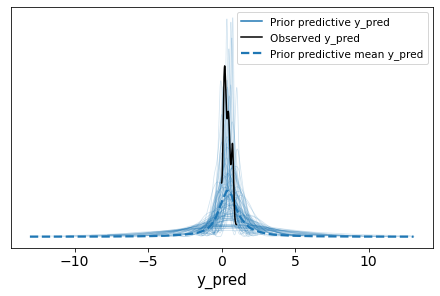

In [17]:
##### Part 6: Sampling ######

## sample prior
with m0:
    prior_pred = pm.sample_prior_predictive(100) # like setting this low. 
    m0_idata = az.from_pymc3(prior=prior_pred)

az.plot_ppc(m0_idata, group="prior")

## convenience function 
def sample_mod(
    model, 
    posterior_draws = 1000, 
    post_pred_draws = 1000,
    prior_pred_draws = 500):
    
    with model: 
        trace = pm.sample(
            return_inferencedata = False, 
            draws = posterior_draws,
            target_accept = .95) # tuning!
        post_pred = pm.sample_posterior_predictive(trace, samples = post_pred_draws)
        prior_pred = pm.sample_prior_predictive(samples = prior_pred_draws)
        m_idata = az.from_pymc3(trace = trace, posterior_predictive=post_pred, prior=prior_pred)
    
    return m_idata

In [18]:
## sample posterior & predictive
m0_idata = sample_mod(m0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_line, beta_month_waves, p_month, beta_week_waves, p_week]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 573 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.882945305972848, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


array([[<AxesSubplot:title={'center':'beta_week_waves'}>,
        <AxesSubplot:title={'center':'beta_week_waves'}>],
       [<AxesSubplot:title={'center':'beta_month_waves'}>,
        <AxesSubplot:title={'center':'beta_month_waves'}>],
       [<AxesSubplot:title={'center':'beta_line'}>,
        <AxesSubplot:title={'center':'beta_line'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'p_week'}>,
        <AxesSubplot:title={'center':'p_week'}>],
       [<AxesSubplot:title={'center':'p_month'}>,
        <AxesSubplot:title={'center':'p_month'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

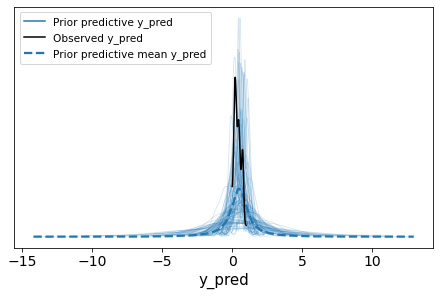

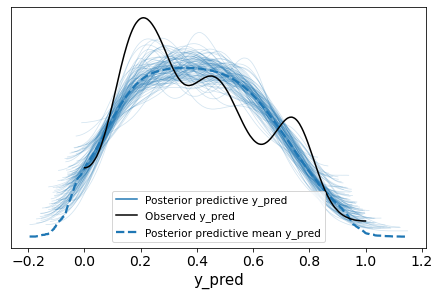

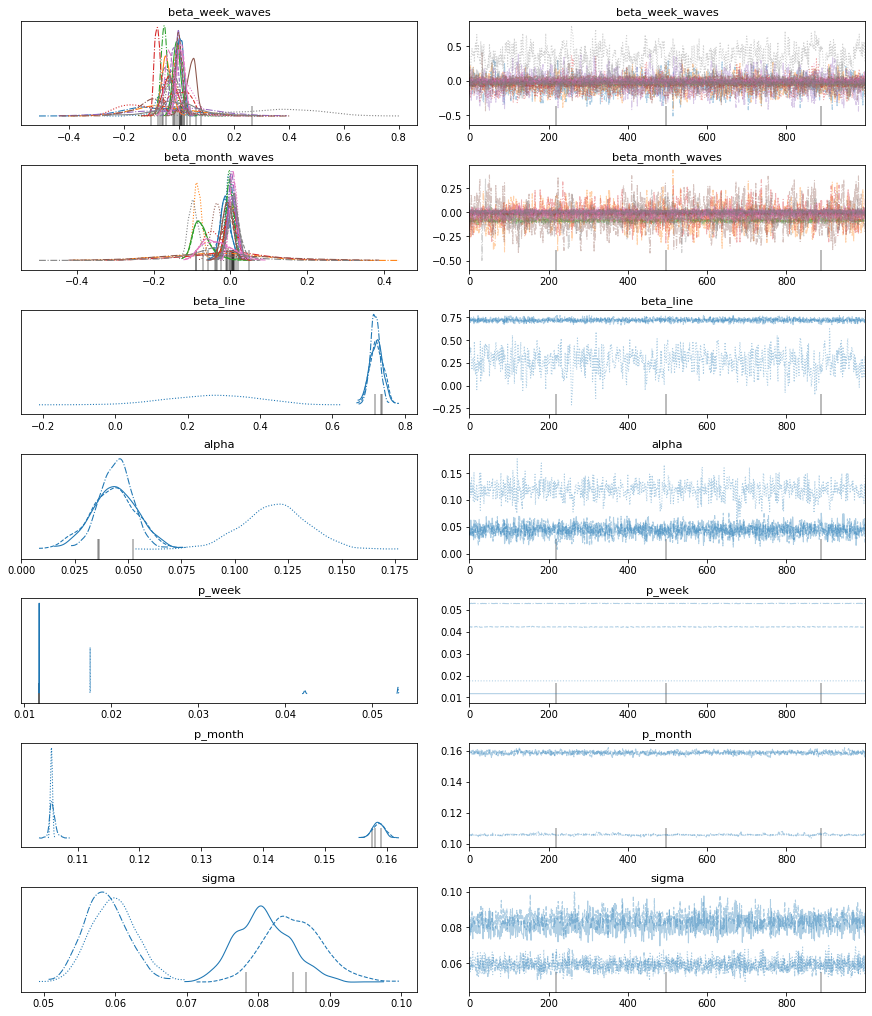

In [32]:
## plot checks 
az.plot_ppc(m0_idata, num_pp_samples = 100, group = "prior")
az.plot_ppc(m0_idata, num_pp_samples = 100)

## plot trace
az.plot_trace(m0_idata)

In [57]:
###### Part 7: check fit to data #######
m_pred = m0_idata.posterior_predictive.mean(axis = 0)

In [58]:
m_pred = m_pred["y_pred"]

In [59]:
m_pred_std = m_pred.std(axis = 0).data
m_pred = m_pred.mean(axis = 0).data

In [73]:
train[time] = pd.to_datetime(train[time])
test[time] = pd.to_datetime(test[time])

<ipython-input-73-0733cca6957c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[time] = pd.to_datetime(train[time])
<ipython-input-73-0733cca6957c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[time] = pd.to_datetime(test[time])


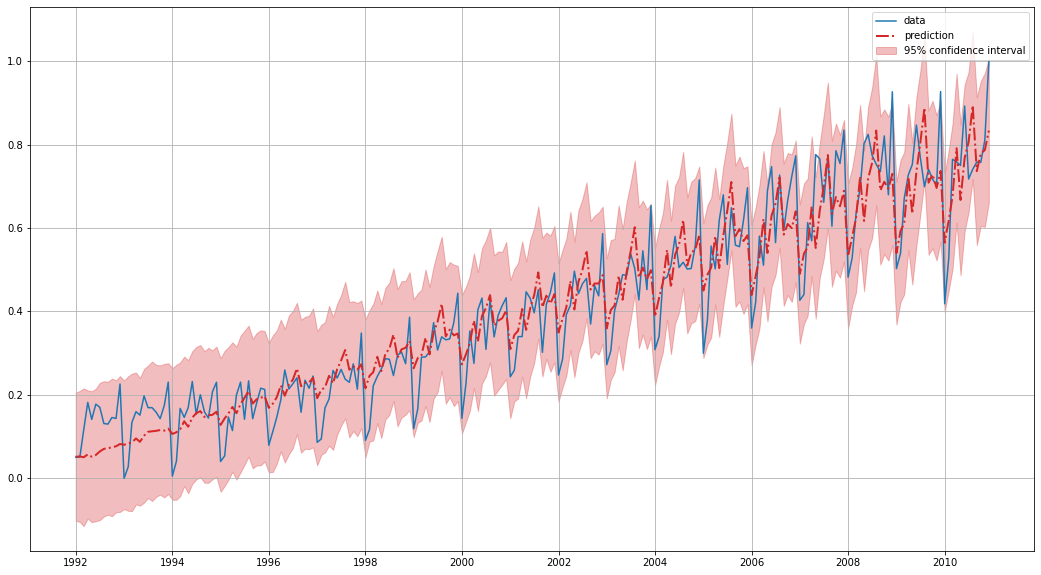

In [63]:
# plot them 
fig, ax = plt.subplots(figsize = (18, 10))
ax.plot(train[time].values, y_train, label = "data", linewidth = 1.5)
ax.plot(train[time].values, m_pred, ls="-.", label = "prediction", color = "C3", linewidth = 2)
ax.fill_between(train[time].values, 
                m_pred -1.96 * m_pred_std, 
                m_pred + 1.96 * m_pred_std, 
                alpha=0.3, 
                label = "95% confidence interval",
                color = "C3")
ax.grid()
ax.legend()

In [65]:
with m0:
    pm.set_data({"t1_shared": t1_test})
    pm.set_data({"t2_shared": t2_test})
    pm.set_data({"idx_shared": idx_test})
    pm.set_data({"t3_shared": np.array(t3_test)})
    m_new_pred = pm.fast_sample_posterior_predictive(
        m0_idata.posterior
    )

In [75]:
m_pred_test = m_new_pred["y_pred"].mean(axis = 0)
m_pred_test_std = m_new_pred["y_pred"].std(axis = 0)

In [78]:
y_train

array([0.05080722, 0.05068851, 0.11526591, 0.18198006, 0.14126306,
       0.17782526, 0.17034663, 0.13129155, 0.12998575, 0.14577398,
       0.14351852, 0.2261396 , 0.        , 0.02730294, 0.13402184,
       0.15978158, 0.15147198, 0.19764957, 0.16939696, 0.16927825,
       0.15823837, 0.14304368, 0.17438272, 0.23065052, 0.00522317,
       0.04107312, 0.16761633, 0.1460114 , 0.16963438, 0.23195632,
       0.15349003, 0.20037987, 0.15942545, 0.14446819, 0.20809592,
       0.2302944 , 0.04024217, 0.05377493, 0.14696106, 0.11431624,
       0.19990503, 0.23065052, 0.14150047, 0.23373694, 0.14292498,
       0.18079297, 0.21604938, 0.21308167, 0.07929725, 0.11301045,
       0.1461301 , 0.18850902, 0.25973409, 0.21426876, 0.22673314,
       0.24109687, 0.15835708, 0.23516144, 0.21593067, 0.24525166,
       0.08630104, 0.09425451, 0.16892213, 0.19040836, 0.25866572,
       0.24050332, 0.26115859, 0.23777303, 0.23017569, 0.27433523,
       0.21367521, 0.3482906 , 0.09081197, 0.11728395, 0.22162

In [79]:
y_test

array([0.31027018, 0.39950293, 0.54525776, 0.50108234, 0.55608114,
       0.6664796 , 0.48705203, 0.59632807, 0.56554157, 0.52761966,
       0.58502365, 0.67762367, 0.35717149, 0.44977151, 0.53539646,
       0.51246693, 0.66631925, 0.66086747, 0.54630001, 0.65196825,
       0.5212058 , 0.61917742, 0.63513188, 0.71281969, 0.43004891,
       0.46957428, 0.5675459 , 0.59825222, 0.73655095, 0.6697667 ,
       0.65381223, 0.67594003, 0.5983324 , 0.68219354, 0.64996392,
       0.77591598, 0.44303696, 0.48328389, 0.56313637, 0.63705604,
       0.70239718, 0.71137657, 0.63609396, 0.63737673, 0.62511024,
       0.70440151, 0.59640824, 0.82410006, 0.43044977, 0.48352441,
       0.61661188, 0.64747855, 0.679628  , 0.79154975, 0.70857051,
       0.65685882, 0.72083701, 0.71771025, 0.67946765, 0.89409124,
       0.45033272, 0.58446244, 0.72765173, 0.67257276, 0.73815441,
       0.8538443 , 0.63489137, 0.77519442, 0.7408803 , 0.71145675,
       0.80052914, 0.91317245, 0.48200112, 0.59496512, 0.75763

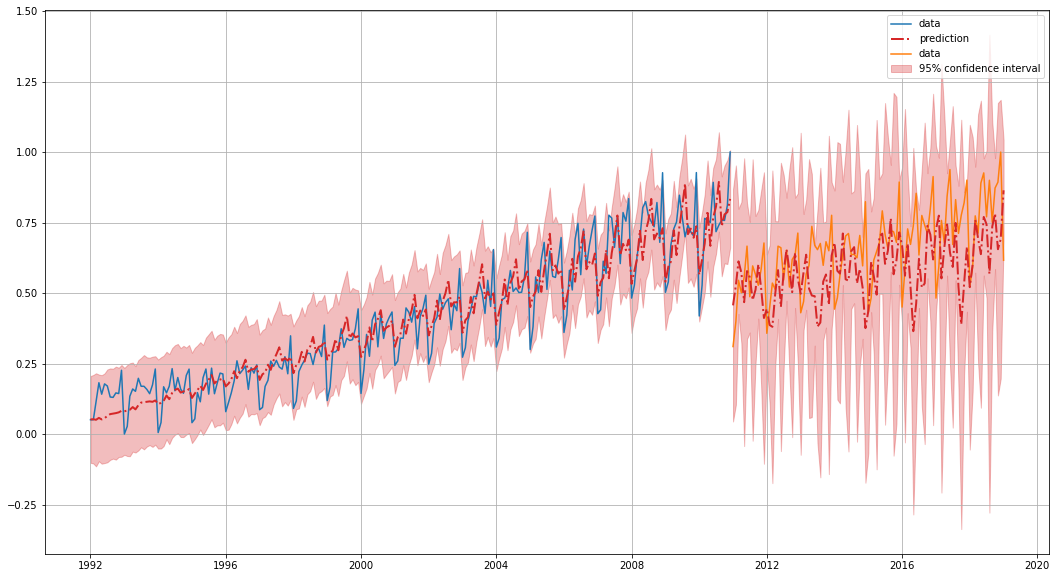

In [77]:
# plot them 
fig, ax = plt.subplots(figsize = (18, 10))
ax.plot(train[time].values, y_train, label = "data", linewidth = 1.5)
ax.plot(train[time].values, m_pred, ls="-.", label = "prediction", color = "C3", linewidth = 2)
ax.fill_between(train[time].values, 
                m_pred -1.96 * m_pred_std, 
                m_pred + 1.96 * m_pred_std, 
                alpha=0.3, 
                label = "95% confidence interval",
                color = "C3")

ax.plot(test[time].values, y_test, label = "data", linewidth = 1.5)
ax.plot(test[time].values, m_pred_test, ls="-.", color = "C3", linewidth = 2)
ax.fill_between(test[time].values, 
                m_pred_test -1.96 * m_pred_test_std, 
                m_pred_test + 1.96 * m_pred_test_std, 
                alpha=0.3,
                color = "C3")
ax.grid()
ax.legend()